In [389]:
import pymc3 as pm
import theano.tensor as T
import theano

from datetime import datetime, timedelta
from collections import defaultdict
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec

import astropy.units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time
from astropy.coordinates import get_sun

# Phenological Model

## Load Count Data

In [302]:
dfCounts = pd.read_excel("./Supplement/S10.xlsx").drop(columns="Unnamed: 0")
dfCounts

,colony_name,ts,Count,CountChicks
0,Atka Bay,2018-04-14 14:08:50,2763.0,NaN
1,Atka Bay,2018-04-30 11:28:41,4651.0,NaN
2,Atka Bay,2018-05-01 10:18:16,12813.0,NaN
3,Atka Bay,2018-05-20 12:10:06,18707.0,NaN
4,Atka Bay,2018-05-25 12:54:12,21466.0,NaN
...,...,...,...,...
523,Pointe Géologie,2021-11-26 00:00:00,1271.0,2519.0
524,Pointe Géologie,2021-12-02 00:00:00,309.0,2014.0
525,Pointe Géologie,2021-12-09 00:00:00,104.0,587.0
526,Pointe Géologie,2021-12-15 00:00:00,9.0,117.0


In [303]:
# get the day of the season and the season from timestamps (season starts on March 1st)
dfCounts["ts2"] = pd.to_datetime([datetime(2011 + (M<3), 1, 1) + timedelta(days=d,hours=h,minutes=m, seconds=s) for M,d,h,m,s in zip(
    dfCounts["ts"].dt.month, dfCounts["ts"].dt.dayofyear, dfCounts["ts"].dt.hour, dfCounts["ts"].dt.minute, dfCounts["ts"].dt.second)])
dfCounts["season"] = dfCounts["ts"].dt.year - (dfCounts["ts"].dt.month<3)
dfCounts["day"] = (dfCounts["ts2"]-datetime(2011,1,1)).dt.days

## Plot count data

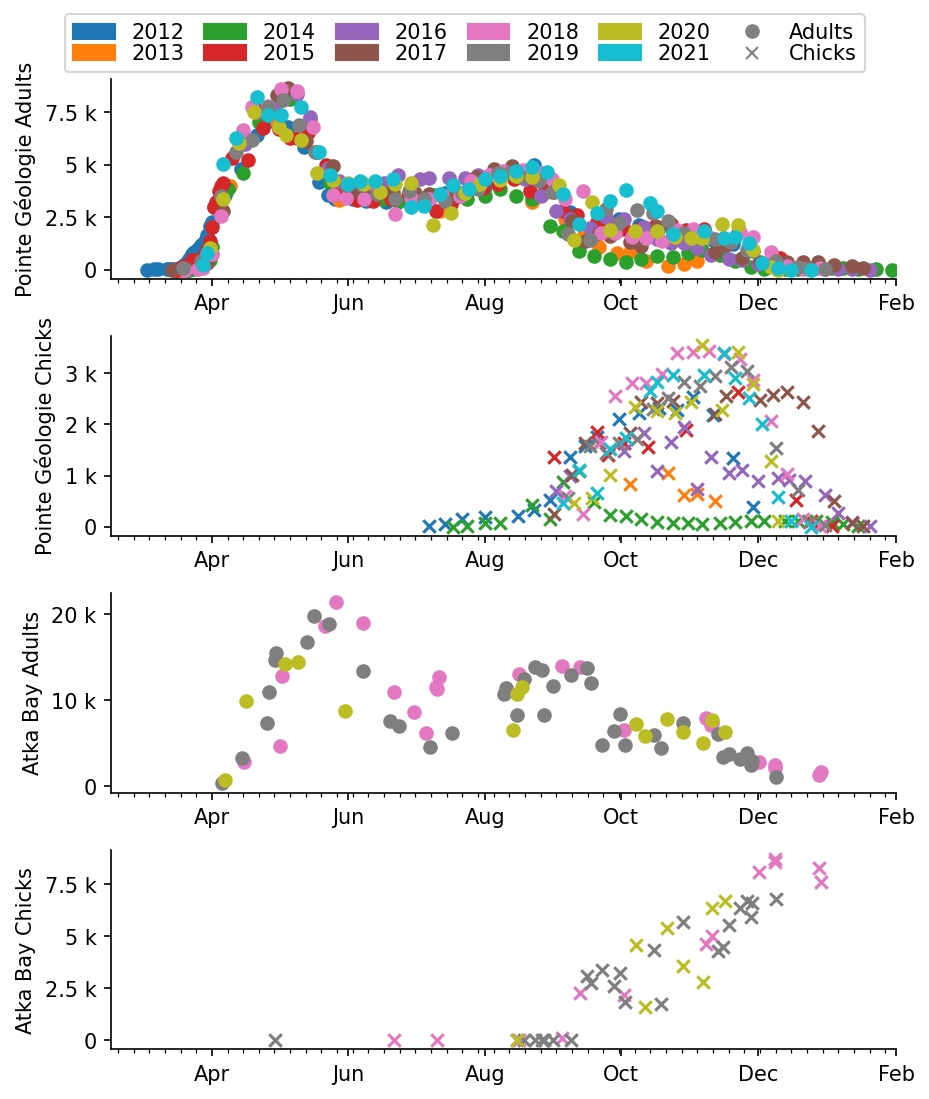

In [86]:
fig, axes = plt.subplots(4,1, figsize=(6.3, 7), dpi=150)

for i, s in enumerate(sorted(dfCounts["season"].unique())):
    
    m = (dfCounts["season"]==s)&(dfCounts["colony_name"]=="Pointe Géologie")
    ax = axes[0]
    ax.scatter(*dfCounts.loc[m, ["ts2", "Count"]].values.T, color="C%d"%i)
    ax = axes[1]
    ax.scatter(*dfCounts.loc[m, ["ts2", "CountChicks"]].values.T, color="C%d"%i, marker="x")
    
    
    m = (dfCounts["season"]==s)&(dfCounts["colony_name"]=="Atka Bay")
    ax = axes[2]
    ax.scatter(*dfCounts.loc[m, ["ts2", "Count"]].values.T, color="C%d"%i)
    ax = axes[3]
    ax.scatter(*dfCounts.loc[m, ["ts2", "CountChicks"]].values.T, color="C%d"%i, marker="x")


axes[0].set_ylabel("Pointe Géologie Adults")
axes[1].set_ylabel("Pointe Géologie Chicks")
axes[2].set_ylabel("Atka Bay Adults")
axes[3].set_ylabel("Atka Bay Chicks")

for ax in axes:
    ax.set_xlim(datetime(2011,2,15), datetime(2012,2,1))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    
    ax.yaxis.set_major_formatter(mtick.EngFormatter(unit=''))
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

ax = axes[0]
handlesY = [ax.fill_between([],[],[],label="%d"%(2012+d), color="C%d"%d) for d in range(10)]
handles =[
        ax.plot([],[],label="Adults", linestyle="none", marker="o", color="Grey")[0],
        ax.plot([],[],label="Chicks", linestyle="none", marker="x", color="Grey")[0],
]
fig.legend(loc="upper center", handles=[*handlesY, *handles],
                         ncol=6, bbox_to_anchor=(0.5,1.05), labelspacing=0.05, columnspacing=0.97)

fig.tight_layout()
    

## Define phenological model

In [26]:
def norm_cdf(x):
    return 0.5 + 0.5*pm.math.erf(x/2**0.5)
def sig(x):
    return 1./(1+T.exp(-x))

class AbundanceModel(pm.Model):

    def __init__(self, *args, name="", model=None, **kwargs):
        super().__init__(name, model)
        self.create(*args, **kwargs)

    def create(self, t_tsd, overlapTrips = 3, singleTrips = 10, nSamples=11, observed={}):
        # Create the prior distributions for model parameters
        # This part would be altered to change prior distributions, include hyperparameters, fix values, etc.
        shape0 = (nSamples,)
        shape1 = (11,nSamples,)
        shape2 = ( 7,nSamples,)
        self.t_tsd = t_tsd
        
        self.shape0 = shape0
        self.shape1 = shape1
        self.shape2 = shape2
        
        # number of breeding pairs (BP) for each season (shape0)
        # min and max are valid values for PG and AB but should be changed for smaller/bigger colonies.
        self.N_mu = pm.Uniform("nPairs", lower=2e3, upper=50e3, shape=shape0)
        
        # Ratios: proportion of non-breeders (NB), hatching success(H), and fledging success(F), all between 0-1 for each season
        # breeding success is BP*H*F
        self.nonBreederProportion = 1 + pm.Uniform("nonBreederProportion", lower=0, upper=1.0, shape=shape0)
        self.hatchingSuccess = pm.Uniform("hatchingSuccess", lower=0, upper=1, shape=shape0)
        # Fledging success is broken into 7 steps (shape2[0]) to create an exponential decrease of number of chicks left during the creching period
        self.fledgingSuccess = pm.Uniform("fledgingSuccess", lower=0, upper=1.0, shape=(1,)+shape0)**(1/shape2[0]) *  T.ones(shape=shape2)
        
        # arrival time (somwhere between march and end of mai)
        self.arrivalTime_mu = pm.Uniform("arrivalLoc", lower=50, upper=150, shape=shape0)
        # arrival time distribution width
        self.arrivalTime_sd = pm.Uniform("arrivalStd", lower=4, upper=14, shape=shape0)
            
        # courtship duration (m)
        self.matingTime_mu = pm.Uniform("matingTime", lower=32, upper=44, shape=shape0)
        # former slot for courtship distribution width -> now we use the arrival time distribution width
        self.matingTime_sd = T.zeros(shape0)
        
        # incubation (female absence time) duration
        self.breedingTime_mu = pm.Uniform("breedingTime", lower=45, upper=85, shape=shape0)
        # incubation duration distribution width
        self.breedingTime_sd = pm.Uniform("breedingStd", lower=1, upper=14, shape=shape0)
        
        # Maximal time at colony during creching
        col_max = pm.Uniform("col_max",  lower=1, upper=5, shape=(1,)+shape0)
        # Minimal time at colony during creching
        col_min = pm.Uniform("col_min",  lower=4/24, upper=col_max, shape=(1,)+shape0)
        # Maximal time at sea during creching
        sea_max = pm.Uniform("sea_max",  lower=col_max, upper=21, shape=(1,)+shape0)
        # Time at sea during first female trip
        sea_fem = pm.Uniform("sea_fem",  lower=col_max, upper=sea_max, shape=(1,)+shape0)
        # Minimal time at sea during creching
        sea_min = pm.Uniform("sea_min",  lower=col_max, upper=sea_max, shape=(1,)+shape0)
        
        # Now we create arrays (col_mu, col_sd, sea_mu, sea_sd), that hold the trip duration means (and standard deviation)
        # Note that these are durations, not time points, yet.
        
        # Create a linear slope between minimum and maximum time at colony
        One2Zero = 1 - T.arange(shape1[0]+1)/shape1[0]
        self.col_mu = (col_max-col_min)*One2Zero[:-1,None] + col_min
        # One trip duration at the end, for the chicks to fledge after all parents left
        self.last_mu = ((col_max-col_min)*One2Zero[-1:,None] + col_min)[0]
        
        # Create a linear slope between minimum and maximum time at sea
        One2Zero = T.minimum(1, 1 - (T.arange(shape1[0])-1)/(shape1[0]-2))
        self.sea_mu = (sea_max-sea_min)*One2Zero[:,None] + sea_min
        # entry at 1 and 2 are female trip duration
        self.sea_mu = T.where(T.eq(T.arange(shape1[0]),1)[:,None],sea_fem ,self.sea_mu)
        self.sea_mu = T.where(T.eq(T.arange(shape1[0]),2)[:,None],sea_fem ,self.sea_mu)
        # compensate for trip duration removal at position 2
        self.sea_mu = T.where(T.eq(T.arange(shape1[0]),3)[:,None],self.sea_mu-sea_fem ,self.sea_mu)
        
        # former slots for individual distribution widths for every trip, now we use the incubation duration distribution width
        self.last_sd = 0*T.ones(shape=shape0)
        self.col_sd =  0*T.ones(shape=shape1)
        self.sea_sd =  0*T.ones(shape=shape1)
        self.build()
    
    def build(self):    
        # build the model from the parameters, this part is fully deterministic.
        # it builts up on the prior distributions for time durations and animal ratios and does all the calculations to get to individual numbers
        # it holds the model structure and is independet of parameter distribution choice.
        shape0 = self.shape0
        shape1 = self.shape1
        shape2 = self.shape2
        
        # Array of ones per season
        I = T.ones(shape0)[None,:]
        # Array of zeros per season
        O = T.zeros(shape0)[None,:]
        # Declaration of one letter parameters for readability
        B = self.nonBreederProportion[None,:]
        H = self.hatchingSuccess[None,:]
        # F was broken into equal values (seventh root of total fledging success), cumprod creates a dereasing value down to F (last value in F_)
        # multiply H to incorporate lost eggs
        F_ = H * T.cumprod(self.fledgingSuccess, axis=0)
        
        # duplicate array: F0,F0, F1,F1, ... to get departure and return covered
        FF = T.repeat(F_, 2, axis=0)
        # DD is like FF, but it only incorporates departures (chick deaths), no returns.
        DD = T.concatenate([(F_[:-1]-F_[1:])[None,:,:], T.zeros((1,shape2[0]-1,)+shape0)], axis=0).transpose((1,0,2)).reshape((-1,)+shape0)
        
        # get some special values (first and last) from F
        F0 = F_[:1]
        DL = F_[-1:]
        # D0 number of living chicks, that emancipate at start of creching
        D0 = H-F0
        
        # Split F (adult ratio during fleding) and D (chick ratio during fledging) into 6 and 7 individual values
        F0, F1, F2, F3, F4, F5, F6 = T.split(F_, (1,)*7, 7, axis=0)
        D1, D2, D3, D4, D5, D6 = T.split(F_[:-1]-F_[1:], (1,)*6, 6, axis=0)
        # The Factors are the ratios of animals, that participate in one of the events (heights of the distributions)
        # One set of factors for male (M), female (F), chicks (C) and visible chicks (V).
        # Visible chicks are the ones thermally emmancipated, that can actually be counted
        # 0 = animal group does not participate in this event
        # I = all animals of this group participate
        # +/- indicate arrival and departure. +/- are alternated, startin with a arrival (+) and ending with a departure (-)
        # other values are ratios:
        # B= 1+nonBreeders, H=hatchingSuccess, F0-F6 fledging success, G0-G6 = H-F
        #                             A,  B,  B,     H, G0, G1, G1, G2,  G2,  G3, G3,  R0,  R0,  R1,  R1,  R2,  R2,  R3,  R3,  R4,  R4,  R5,  R5,  R6,  R6,   L,
        #                             I,  O,  I,     O,  I,  O,  I,  O,   I,   O,  I,   O,   I,   O,   I,   O,   I,   O,   I,   O,   I,   O,   I,   O,   I,   O, 
        #                             S,  C,  S,     C,  S,  C,  S,  C,   S,   C,  S,   C,   S,   C,   S,   C,   S,   C,   S,   C,   S,   C,   S,   C,   S,   C,
        #                             A,  M,  B,    C0, S0, C1, S1, C2,  S2,  C3, S3,  C3,  S3,  C4,  S4,  C5,  S5,  C6,  S6,  C7,  S7,  C8,  S8,  C9,  S9,  CL, 
        self.factorM = T.concatenate([I,  O, -I,     O,  H,  O,  O, -H,   O,   O, F0, -F0,  F1, -F1,  F2, -F2,  F3, -F3,  F4, -F4,  F5, -F5,  F6, -F6,  O,   O,])
        self.factorF = T.concatenate([B, -B,  I,-(I-H),  O, -H,  H,  O,  -H,   O, F0, -F0,  F1, -F1,  F2, -F2,  F3, -F3,  F4, -F4,  F5, -F5,  F6, -F6,  O,   O,])
        self.factorC = T.concatenate([O,  O,  O,     O,  H,  O,  O,-D0,   O,   O,  O, -D1,   O, -D2,   O, -D3,   O, -D4,   O, -D5,   O, -D6,   O,   O,  O, -DL,])
        self.factorV = T.concatenate([O,  O,  O,     O,  O,  O,  O,  O,   O,   O, F0, -D1,   O, -D2,   O, -D3,   O, -D4,   O, -D5,   O, -D6,   O,   O,  O, -DL,])
        
        # Now we get the duration arrays for colony (c) and sea (s) times, and alternate them (c0,s0,c1,s1,...)
        cs = T.concatenate([self.col_mu[None,:,:], self.sea_mu[None,:,:], ], axis=0).transpose((1,0,2)).reshape((-1,)+shape0)
        # Declaration of one letter parameters for readability
        l = self.last_mu[None,:] # last stay duration, for chicks to fledge
        a = self.arrivalTime_mu[None,:] # arrival time
        m = self.matingTime_mu[None,:] # courtship duration
        b = self.breedingTime_mu[None,:] # incubation (female absence) duration
        
        # as above with the distribution height, now create an array holding the distribution mean values
        # the timings are the same for all types of animals (females, males, chicks), O/I/F/H... decide, who participates in the event
        # B= 1+nonBreeders, H=hatchingSuccess, F0-F6 fledging success, G0-G6 = H-F
        #                             A, B, B, H, G0,G1,G1,G2,G2,G3,G3,R0,R0,R1,R1,R2,R2,R3,R3,R4,R4,R5,R5,R6,R6,L
        #                             I, O, I, O, I, O, I, O, I, O, I, O, I, O, I, O, I, O, I, O, I, O, I, O, I, O, 
        self.timings = T.concatenate([a, m, b,   cs, l,])        

        # iterate the same as above with the distribution widths
        cs = T.concatenate([self.col_sd[None,:,:], self.sea_sd[None,:,:], ], axis=0).transpose((1,0,2)).reshape((-1,)+shape0)
        l = self.last_sd[None,:]
        a = self.arrivalTime_sd[None,:]
        m = self.matingTime_sd[None,:]
        b = self.breedingTime_sd[None,:]
        # B= 1+nonBreeders, H=hatchingSuccess, F0-F6 fledging success, G0-G6 = H-F
        #                               A, B, B, H, G0,G1,G1,G2,G2,G3,G3,R0,R0,R1,R1,R2,R2,R3,R3,R4,R4,R5,R5,R6,R6,L
        #                               I, O, I, O, I, O, I, O, I, O, I, O, I, O, I, O, I, O, I, O, I, O, I, O, I, O, 
        self.timingsSD = T.concatenate([a, m, b,   cs, l,])        
        
        # Get from durations to time points by cummulative sum
        self.timingsSum = T.cumsum(self.timings, axis=0)
        # add the distribution widths vectorial like for real distributions, that are summed
        # note that timingSDSum has as many entries as timing, but only 2 different values:
        # a_sd and (a_sd **2 + b_sd **2)**0.5, because all other entries in timingSD were 0
        self.timingsSDSum = T.cumsum(self.timingsSD**2, axis=0)**0.5
        
        # Now calculate the cummulative distribution function values for each requested day (t_tsd) from time point mean and width
        # Note that these distributions are the same for all types of animals and do not yet contain the height factors
        self.cdf = norm_cdf((self.t_tsd[:,None,None] - self.timingsSum[None,:,:])/self.timingsSDSum[None,:,:])
        
        # multiply the cummulative distribution with the ratios and number of breeders, receiving the number of animals, that went throught he event
        # sum over all events to get the number of individuals that are at the colony
        self.sumM = self.N_mu[None,:]*T.sum(self.cdf*self.factorM[None,:,:], axis=1)
        self.sumF = self.N_mu[None,:]*T.sum(self.cdf*self.factorF[None,:,:], axis=1)
        self.sumC = self.N_mu[None,:]*T.sum(self.cdf*self.factorC[None,:,:], axis=1)
        self.sumV = self.N_mu[None,:]*T.sum(self.cdf*self.factorV[None,:,:], axis=1)
        
        # sum males and females to get number of adults
        self.allPresentP = self.sumM+self.sumF
        # legacy variable naming
        self.allPresentC = self.sumC
        self.allVisibleC = self.sumV


## Fit phenological model

### Create array structure
Create array from dfCounts with size (season)X(day of season) and the number of adults as values

In [53]:
# enumerate the season/colony to fit each season individualy
seasonColonyDict = {
 0: (2012, 'Pointe Géologie'),
 1: (2013, 'Pointe Géologie'),
 2: (2014, 'Pointe Géologie'),
 3: (2015, 'Pointe Géologie'),
 4: (2016, 'Pointe Géologie'),
 5: (2017, 'Pointe Géologie'),
 6: (2018, 'Pointe Géologie'),
 7: (2019, 'Pointe Géologie'),
 8: (2020, 'Pointe Géologie'),
 9: (2021, 'Pointe Géologie'),
 10: (2018, 'Atka Bay'),
 11: (2019, 'Atka Bay'),
 12: (2020, 'Atka Bay'),
}
seasonColonyDict_inv = dict([[v,k] for k,v in seasonColonyDict.items()])
dfCounts["season_colony_id"] = [seasonColonyDict_inv[(s,c)] for s,c in dfCounts[["season", "colony_name"]].values]

# number of adults in season x day shape
adultsCounts = dfCounts.groupby(["season_colony_id", "day"]).mean().unstack()["Count"].values.T
# number of chicks in season x day shape
chickCounts = dfCounts.groupby(["season_colony_id", "day"]).mean().unstack()["CountChicks"].values.T
# day of the season
daysCounts = dfCounts.groupby(["season_colony_id", "day"]).mean().unstack()["Count"].columns.values


### Fit

In [55]:

with AbundanceModel(theano.shared(daysCounts), name="", nSamples=len(seasonColonyDict)) as model:
    # masking array to remove missing data days in each season
    t_abundance_mask = theano.shared(~np.isnan(adultsCounts), broadcastable=(False,False))
    
    # error distribution widths
    sigma = pm.Exponential("sigma", 1/0.1, shape=(1, len(seasonColonyDict)))
    sigmaNB = pm.Exponential("sigmaNB", 1./100, shape=(1, len(seasonColonyDict)))
    
    # observed distribution: this is where data and model are brought together. 
    # theano calculates likelihood functions for the model parameters based on this distribution.
    # The likelihood function is comparable to a loss function in NN: it returns a goodness of fit from observed values and parameter values.
    # It is used for MCMC sampling.
    N_obs = pm.Lognormal('Abundance',
                         mu=T.log(model.allPresentP+sigmaNB)[t_abundance_mask],
                         sd=(sigma * T.ones_like(t_abundance_mask))[t_abundance_mask],
                         observed=adultsCounts[~np.isnan(adultsCounts)]
                        )    
    # The NUT-Sampler (No-U-Turn) optimizes the parameter values for the likelihood function.
    # It is very efficient in number of samples, as it does not run back and forth on the same "line" in the parameter space,
    # but sample computation is more demanding, as it computes multiple interpolation points per step.
    # The NUT-Sampler is especially usefull for complex parameter landscapes like in our optimization.
    nChains = 6
    traceCounts = pm.sample(2000, start=None, step=pm.NUTS(target_accept=0.9), cores=nChains, tune=2000, compute_convergence_checks=False, return_inferencedata=True)
    

Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigmaNB, sigma, sea_min, sea_fem, sea_max, col_min, col_max, breedingTime, breedingStd, matingTime, arrivalStd, arrivalLoc, fledgingSuccess, hatchingSuccess, nonBreederProportion, nPairs]


Sampling 6 chains for 2_000 tune and 2_000 draw iterations (12_000 + 12_000 draws total) took 4387 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


### Posterior predictive sampling of phenological model
We derive model parameters and their distributions from the sampling chain, by calculating the parameter values for each sample.

In [58]:
# helper function to extract values from the posterior predictive chain (ppc)
def arrFromPPC(ppc, key, flatten=True):
    arr = np.asarray(ppc[key], dtype=float)
    if flatten:
        return arr.reshape((-1, *arr.shape[2:])) 
    else:
        return arr
    
with AbundanceModel(theano.shared(daysCounts), name="", nSamples=len(seasonColonyDict)) as model:
    t_abundance_mask = theano.shared(~np.isnan(adultsCounts), broadcastable=(False,False))
    # error distribution widths
    sigma = pm.Exponential("sigma", 1/0.1, shape=(1, len(seasonColonyDict)))
    sigmaNB = pm.Exponential("sigmaNB", 1./100, shape=(1, len(seasonColonyDict)))

    # create observed value as above (to sample the distribution of number of individuals per day)
    N_obs = pm.Lognormal('Abundance',
                         mu=T.log(model.allPresentP+sigmaNB)[t_abundance_mask],
                         sd=(sigma * T.ones_like(t_abundance_mask))[t_abundance_mask],
                         observed=adultsCounts[~np.isnan(adultsCounts)]
                        )    
    # Same as above, but without the masking, to interpolate the missing adult count values.
    N2_obs = pm.Lognormal('Abundance2',
                     mu=T.log(model.allPresentP+sigmaNB),
                     sd=(sigma * T.ones_like(t_abundance_mask)),
                     observed=np.zeros_like(adultsCounts), # the observed value does not play a role anymore after sampling, it just helps theano to get the array shapes right
                    )    

    # legacy parameter renaming
    model.m_mu_sum = model.timingsSum
    model.f_mu_sum = model.timingsSum
    model.m_factors = model.factorM
    model.f_factors = model.factorF
    model.c_factors = model.factorC
    
    obs = [
    N_obs, # number of adults for each observed day (with error distribution)
    N2_obs, # number of adults for every day (with error distribution)
    
    # the followin "deterministic" values are predicted from the model parameter distributions and do not carry an additonal observation error distribution
    pm.Deterministic('abundance', model.allPresentP + sigmaNB), # predicted number of adults for every day
    pm.Deterministic('chick_abundance', model.allPresentC),  # predicted number of living chicks for every day
    pm.Deterministic('chickV_abundance', model.allVisibleC), # predicted number of emmancipated chicks for every day
    pm.Deterministic('m_mu_sum', model.m_mu_sum), # male timings (legacy)
    pm.Deterministic('f_mu_sum', model.f_mu_sum), # female timings (legacy)
    pm.Deterministic('m_factors', model.m_factors), # male event participation ratio
    pm.Deterministic('f_factors', model.f_factors), # female event participation ratio
    pm.Deterministic('c_factors', model.c_factors), # chick event participation ratio
    pm.Deterministic("timingsSD", model.timingsSD), # timing distribution width (pre sum), most entries are 0
    pm.Deterministic("timingsSDSum", model.timingsSDSum), # timing distribution width
    pm.Deterministic("timingsSum", model.timingsSum),# timings
    pm.Deterministic("cdf", model.cdf), # cummulative density distribution for plotting
    ]
    # perform posterior predictive sampling
    count_ppc = pm.fast_sample_posterior_predictive(traceCounts, var_names=[rv.name for rv in obs], keep_size=True)

# extract distribution values from ppc    
abundancePPC =       arrFromPPC(count_ppc, "Abundance2")
directAbundancePPC = arrFromPPC(count_ppc, "abundance")
abundanceChicks =    arrFromPPC(count_ppc, "chick_abundance")
abundanceChicksV =   arrFromPPC(count_ppc, "chickV_abundance")
m_mu_sum =           arrFromPPC(count_ppc, "m_mu_sum")
f_mu_sum =           arrFromPPC(count_ppc, "f_mu_sum")
m_factors =          arrFromPPC(count_ppc, "m_factors")
f_factors =          arrFromPPC(count_ppc, "f_factors")
c_factors =          arrFromPPC(count_ppc, "c_factors")
timingsSD =          arrFromPPC(count_ppc, "timingsSD")
timingsSDSum =       arrFromPPC(count_ppc, "timingsSDSum")
timingsSum =         arrFromPPC(count_ppc, "timingsSum")
cdf =                arrFromPPC(count_ppc, "cdf")


## Model Evaluation

### Plot phenological model fit

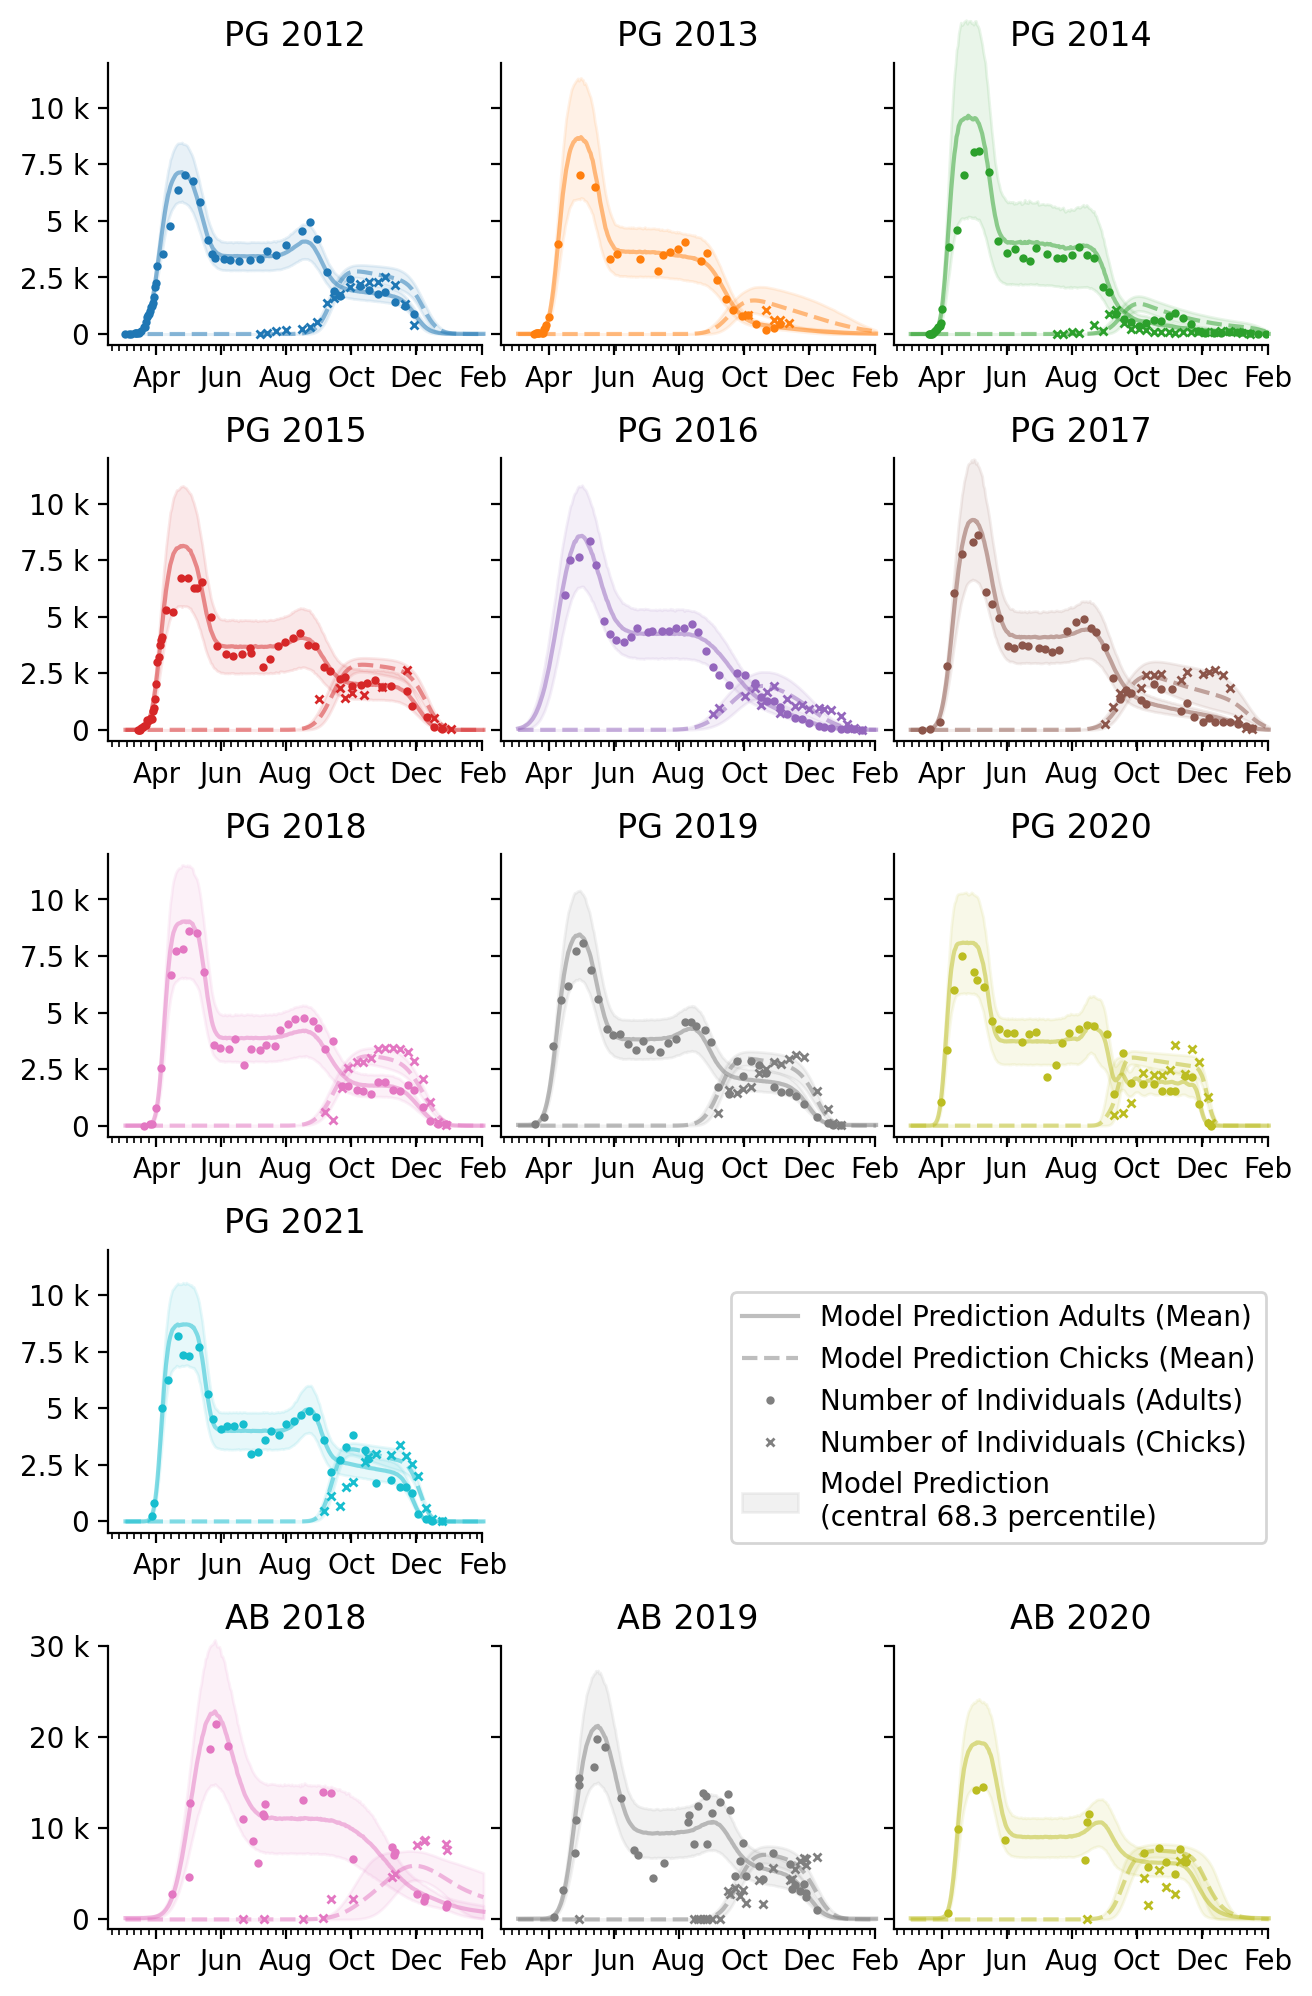

In [231]:
one_sigma = 68.3
one_sigma_interval = (50-one_sigma/2, 50+one_sigma/2)

ts_days = np.array([datetime(2011,1,1) + timedelta(days=int(d)) for d in days])

fig, axes = plt.subplots(5,3,dpi=200, figsize=(6.3,9.8))

axesPG = axes.flatten()[:10]
axesAB = axes.flatten()[12:]
axes_plot = [*axesPG,*axesAB]

for i, (s,c) in seasonColonyDict.items():
    ax = axes_plot[i]
    iS = s-2012
    m = (dfCounts["season"]==s)&(dfCounts["colony_name"]==c)
    
    ax.plot(*dfCounts.loc[m, ["ts2", "Count"]].values.T, color="C%d"%iS, marker="o", markersize=2, linestyle="none")
    ax.plot(*dfCounts.loc[m, ["ts2", "CountChicks"]].values.T, color="C%d"%iS, marker="x", markersize=3, linestyle="none")
    
    ax.fill_between(ts_days, *np.percentile(abundancePPC[:,:,i], one_sigma_interval, axis=0), color="C%d"%iS, alpha=0.1, clip_on=False, zorder=-1)
    ax.fill_between(ts_days, *np.percentile(abundanceChicksV[:,:,i], one_sigma_interval, axis=0), color="C%d"%iS, alpha=0.1, clip_on=False, zorder=-1)
    
    ax.plot(ts_days, abundancePPC[...,i].mean(0), color="C%d"%iS, linestyle="-", alpha=0.5, clip_on=False)
    ax.plot(ts_days, abundanceChicksV[...,i].mean(0), color="C%d"%iS, linestyle="--", alpha=0.5, clip_on=False)
    
    shorthand = {"Atka Bay":"AB", "Pointe Géologie":"PG"}
    ax.set_title(" ".join([shorthand[c], str(s)]))
    
for ax in axesPG:
    ax.set_ylim(-5e2, 12e3)
for ax in axesAB:
    ax.set_ylim(-1e3, 30e3)
    
for ax in axes_plot:
    ax.set_xlim(datetime(2011,2,15), datetime(2012,2,1))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    
    ax.yaxis.set_major_formatter(mtick.EngFormatter(unit=''))
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

for ax in axes[:,1:].flatten():
    ax.set(yticklabels=[])
    
fig.delaxes(axes[3,2])
fig.delaxes(axes[3,1])

ax = axes[0,0]
handles = [
    ax.plot([],[], color="Grey", linestyle="-", alpha=0.5, label="Model Prediction Adults (Mean)")[0],
    ax.plot([],[], color="Grey", linestyle="--", alpha=0.5, label="Model Prediction Chicks (Mean)")[0],
    ax.plot([],[], markersize=2, marker="o", linestyle="none", color="Grey", label="Number of Individuals (Adults)")[0],
    ax.plot([],[], markersize=3, marker="x", linestyle="none", color="Grey", label="Number of Individuals (Chicks)")[0],
    ax.fill_between([],[],[], color="Grey", alpha=0.1, label="Model Prediction\n(central 68.3 percentile)"),
]

fig.legend(loc="center right", handles=handles, bbox_to_anchor=(1., 2/7))

fig.subplots_adjust(left=0.07, bottom=0.025, right=1-0.01, top=1-0.023, wspace=0.05, hspace=0.4)


### Load manually observed phenological events

In [223]:
dfEvents = pd.read_excel("./Supplement/S11.xlsx")
# remove predicted values, let's start fresh :-)
dfEvents = dfEvents[dfEvents["Value"]!="predicted"]
dfEvents

,Value,Event,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,true,Arrival,2012-03-26,2013-04-06,2014-03-31,2015-03-30,2016-03-31,2017-04-01,2018-04-12,2019-04-05,2020-03-31,2021-03-29
2,true,Female Departure,2012-05-02,2013-04-30,2014-05-05,2015-05-12,2016-04-29,2017-04-26,2018-05-05,2019-05-03,2020-05-05,2021-05-02
4,true,Female Return,2012-07-05,2013-07-26,2014-07-31,2015-07-18,2016-07-19,2017-07-27,2018-07-29,2019-07-26,2020-07-19,2021-07-26
6,true,Male Return,NaT,2013-08-19,2014-08-11,2015-08-04,2016-08-01,2017-08-06,2018-08-08,2019-08-08,2020-08-06,2021-08-09
8,true,Emancipation,2012-08-23,2013-08-19,2014-08-16,2015-08-20,2016-08-17,2017-08-19,2018-08-17,2019-08-15,2020-08-09,2021-08-16
10,true,Fledging,2012-12-14,NaT,2015-01-07,NaT,2016-12-30,2017-12-27,2018-12-04,NaT,2020-12-03,2021-12-02


### Predict Event Timing

In [224]:
one_sigma = 68.3
one_sigma_interval = (50-one_sigma/2, 50+one_sigma/2)

t0 = np.array([datetime(y, 1, 1).timestamp() for y,c in seasonColonyDict.values()])
predArrival =         np.array(t0 + 3600*24*np.mean(f_mu_sum, axis=0)[0,:], dtype="datetime64[s]")
predFemaleDeparture = np.array(t0 + 3600*24*np.mean(f_mu_sum, axis=0)[1,:], dtype="datetime64[s]")
predFemaleReturn =    np.array(t0 + 3600*24*np.mean(f_mu_sum, axis=0)[2,:], dtype="datetime64[s]")
predMaleReturn =      np.array(t0 + 3600*24*np.mean(m_mu_sum, axis=0)[4,:], dtype="datetime64[s]")
predEmancipation =    np.array(t0 + 3600*24*np.mean(m_mu_sum, axis=0)[7,:], dtype="datetime64[s]")
predFledging   =      np.array(t0 + 3600*24*np.mean(m_mu_sum, axis=0)[-1,:], dtype="datetime64[s]")

dfEvents = dfEvents.set_index(["Value", "Event"]).T
dfEvents[("predicted", "Arrival")] = predArrival[:10]
dfEvents[("predicted", "Female Departure")] = predFemaleDeparture[:10]
dfEvents[("predicted", "Female Return")] = predFemaleReturn[:10]
dfEvents[("predicted", "Male Return")] = predMaleReturn[:10]
dfEvents[("predicted", "Emancipation")] = predEmancipation[:10]
dfEvents[("predicted", "Fledging")] = predFledging[:10]

dfEvents = dfEvents.T.reset_index().sort_values("Event")
dfEvents

,Value,Event,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,true,Arrival,2012-03-26 00:00:00,2013-04-06 00:00:00,2014-03-31 00:00:00,2015-03-30 00:00:00,2016-03-31 00:00:00,2017-04-01 00:00:00,2018-04-12 00:00:00,2019-04-05 00:00:00,2020-03-31 00:00:00,2021-03-29 00:00:00
6,predicted,Arrival,2012-04-02 19:00:42,2013-04-10 06:41:34,2014-04-07 15:20:37,2015-04-05 05:53:46,2016-04-07 20:51:20,2017-04-11 14:48:45,2018-04-08 10:00:10,2019-04-08 23:05:55,2020-04-04 04:46:40,2021-04-05 23:02:56
4,true,Emancipation,2012-08-23 00:00:00,2013-08-19 00:00:00,2014-08-16 00:00:00,2015-08-20 00:00:00,2016-08-17 00:00:00,2017-08-19 00:00:00,2018-08-17 00:00:00,2019-08-15 00:00:00,2020-08-09 00:00:00,2021-08-16 00:00:00
10,predicted,Emancipation,2012-08-28 17:25:24,2013-09-02 00:36:12,2014-08-27 03:57:34,2015-08-29 18:18:55,2016-09-05 14:18:03,2017-08-30 22:11:40,2018-09-01 08:27:48,2019-08-25 03:22:44,2020-08-28 03:27:35,2021-08-31 11:59:43
1,true,Female Departure,2012-05-02 00:00:00,2013-04-30 00:00:00,2014-05-05 00:00:00,2015-05-12 00:00:00,2016-04-29 00:00:00,2017-04-26 00:00:00,2018-05-05 00:00:00,2019-05-03 00:00:00,2020-05-05 00:00:00,2021-05-02 00:00:00
7,predicted,Female Departure,2012-05-12 02:01:06,2013-05-17 23:48:39,2014-05-16 00:58:37,2015-05-14 20:12:12,2016-05-15 21:08:11,2017-05-17 13:12:00,2018-05-16 22:32:51,2019-05-16 01:25:17,2020-05-13 04:43:27,2021-05-16 12:24:53
2,true,Female Return,2012-07-05 00:00:00,2013-07-26 00:00:00,2014-07-31 00:00:00,2015-07-18 00:00:00,2016-07-19 00:00:00,2017-07-27 00:00:00,2018-07-29 00:00:00,2019-07-26 00:00:00,2020-07-19 00:00:00,2021-07-26 00:00:00
8,predicted,Female Return,2012-07-29 05:36:26,2013-07-29 05:04:38,2014-07-19 13:00:18,2015-07-28 23:56:48,2016-08-03 05:27:53,2017-07-25 09:47:57,2018-07-29 18:08:39,2019-07-25 16:33:30,2020-07-28 04:35:44,2021-08-03 08:14:45
5,true,Fledging,2012-12-14 00:00:00,NaT,2015-01-07 00:00:00,NaT,2016-12-30 00:00:00,2017-12-27 00:00:00,2018-12-04 00:00:00,NaT,2020-12-03 00:00:00,2021-12-02 00:00:00
11,predicted,Fledging,2012-12-06 09:06:21,2013-12-29 02:45:43,2015-01-26 04:58:31,2015-12-08 22:50:20,2016-12-08 10:07:56,2018-01-12 20:53:45,2018-12-07 15:16:49,2019-12-06 07:31:13,2020-12-05 07:46:11,2021-12-04 03:20:57


### Plot event timing

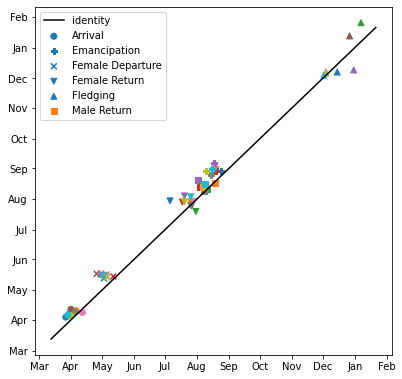

In [226]:
markerdict = {
    'Arrival' : "o",
    'Emancipation': "P",
    'Female Departure': "x",
    'Female Return': "v",
    'Fledging': "^",
    'Male Return':'s',
}
t0 = np.array([datetime(y, 1, 1).timestamp() for y,c in seasonColonyDict.values()]).astype("datetime64[s]")[:10]

fig, ax = plt.subplots(1,1, figsize=(6.4, 6.4))

dfEvent_ = dfEvents.set_index(["Event", "Value"])
for i, key in enumerate(dfEvents["Event"].unique()):
    x = [datetime(2011,1,1) + timedelta(seconds=v) if not np.isnan(v) else np.nan for v in (dfEvent_.loc[(key, "true")]-t0).dt.total_seconds()]
    y = [datetime(2011,1,1) + timedelta(seconds=v) if not np.isnan(v) else np.nan for v in (dfEvent_.loc[(key, "predicted")]-t0).dt.total_seconds()]
    
    x = (dfEvent_.loc[(key, "true")]-t0).dt.total_seconds().values
    y = (dfEvent_.loc[(key, "predicted")]-t0).dt.total_seconds().values
    m = ~(np.isnan(x)|np.isnan(y))
    x =(datetime(2011,1,1).timestamp() + x[m]).astype("datetime64[s]")
    y =(datetime(2011,1,1).timestamp() + y[m]).astype("datetime64[s]")
    ax.scatter(x,y, marker=markerdict[key], c=["C%d"%i for i in np.arange(10)[m]], label=key)
    pass#ax.plot()
xlim,ylim = ax.get_xlim(), ax.get_ylim()
ax.plot(xlim,xlim, color="k", label="identity")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax.yaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax.legend(loc="best")

### Load true breeding success

In [243]:
dfBreedingSuccessT = pd.read_excel("./Supplement/S21.xlsx").drop(columns="Unnamed: 0")
# remove predicted values, let's start fresh :-)
dfBreedingSuccessT = dfBreedingSuccessT[dfBreedingSuccessT["Value"]!="Predicted"]
dfBreedingSuccessT

,nPairs,chicks,deadChicks,deadEggs,season,colony_name,Value
0,3340,2189,NaN,0.0,2012,Pointe Géologie,True
1,3531,501,0.0,0.0,2013,Pointe Géologie,True
2,3784,114,3309.0,479.0,2014,Pointe Géologie,True
3,3611,2635,375.0,436.0,2015,Pointe Géologie,True
4,4494,1363,2128.0,307.0,2016,Pointe Géologie,True
5,3708,2629,718.0,217.0,2017,Pointe Géologie,True
6,3814,3427,162.0,304.0,2018,Pointe Géologie,True
7,4049,3115,251.0,215.0,2019,Pointe Géologie,True
8,4132,3549,165.0,213.0,2020,Pointe Géologie,True
9,4323,3390,207.0,247.0,2021,Pointe Géologie,True


### Predict breeding success (phenology model)

In [252]:
NP = np.array(traceCounts.posterior["nPairs"])
hS = np.array(traceCounts.posterior["hatchingSuccess"])
fS = np.prod(np.array(traceCounts.posterior["fledgingSuccess"]), axis=2)

predChicks = np.mean(NP*hS*fS, axis=(0,1))
predBreeders = np.mean(NP, axis=(0,1))
predDeadchicks = np.mean(NP*hS*(1-fS), axis=(0,1))
predLosteggs = np.mean(NP*(1-hS), axis=(0,1))

dfBreedingSuccessP = pd.DataFrame(np.stack([
    predBreeders,
    predChicks,
    predDeadchicks,
    predLosteggs,
]).T, columns=["nPairs", "chicks", "deadChicks", "deadEggs"])
dfBreedingSuccessP["season"] = [s for s,c in seasonColonyDict.values()]
dfBreedingSuccessP["colony_name"] = [c for s,c in seasonColonyDict.values()]
dfBreedingSuccessP["Value"] = "Predicted"

dfBreedingSuccess = pd.concat([dfBreedingSuccessT, dfBreedingSuccessP]).set_index(["colony_name", "season", "Value"]).sort_index().reset_index()
dfBreedingSuccess

,colony_name,season,Value,nPairs,chicks,deadChicks,deadEggs
0,Atka Bay,2018,True,8834.000000,8739.000000,NaN,NaN
1,Atka Bay,2018,Predicted,10267.768874,4661.658282,4268.879486,1337.231106
2,Atka Bay,2019,True,8223.000000,6814.000000,NaN,NaN
3,Atka Bay,2019,Predicted,8995.098749,6341.118839,2085.953232,568.026678
4,Atka Bay,2020,True,8753.000000,6692.000000,NaN,NaN
5,Atka Bay,2020,Predicted,8640.816302,7246.372243,814.810203,579.633856
6,Pointe Géologie,2012,True,3340.000000,2189.000000,NaN,0.000000
7,Pointe Géologie,2012,Predicted,3373.710489,2387.208439,827.185718,159.316331
8,Pointe Géologie,2013,True,3531.000000,501.000000,0.000000,0.000000
9,Pointe Géologie,2013,Predicted,3468.278631,842.033690,1947.397513,678.847429


### Plot breeding success

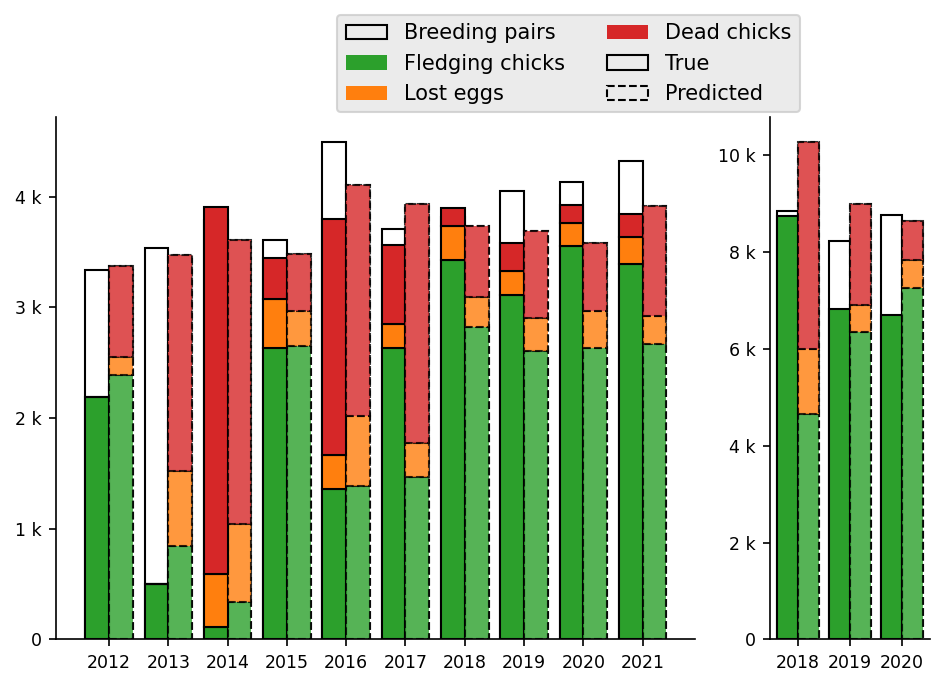

In [300]:
fig, axes = plt.subplots(1,2, figsize=(6.4,4),  gridspec_kw=dict(width_ratios=[0.8, 0.2]), dpi=150)
axPG, axAB = axes
mPGT = (dfBreedingSuccess["colony_name"] == "Pointe Géologie")&(dfBreedingSuccess["Value"]==True)
mPGP = (dfBreedingSuccess["colony_name"] == "Pointe Géologie")&(dfBreedingSuccess["Value"]=="Predicted")
mABT = (dfBreedingSuccess["colony_name"] == "Atka Bay")&(dfBreedingSuccess["Value"]==True)
mABP = (dfBreedingSuccess["colony_name"] == "Atka Bay")&(dfBreedingSuccess["Value"]=="Predicted")

truePGbreeders =   dfBreedingSuccess.loc[mPGT, "nPairs"].values
truePGchicks =     dfBreedingSuccess.loc[mPGT, "chicks"].values
truePGdeadchicks = dfBreedingSuccess.loc[mPGT, "deadChicks"].values
truePGdeadeggs =   dfBreedingSuccess.loc[mPGT, "deadEggs"].values
predPGbreeders =   dfBreedingSuccess.loc[mPGP, "nPairs"].values
predPGchicks =     dfBreedingSuccess.loc[mPGP, "chicks"].values
predPGdeadchicks = dfBreedingSuccess.loc[mPGP, "deadChicks"].values
predPGdeadeggs =   dfBreedingSuccess.loc[mPGP, "deadEggs"].values
trueABbreeders =   dfBreedingSuccess.loc[mABT, "nPairs"].values
trueABchicks =     dfBreedingSuccess.loc[mABT, "chicks"].values
trueABdeadchicks = dfBreedingSuccess.loc[mABT, "deadChicks"].values
trueABdeadeggs =   dfBreedingSuccess.loc[mABT, "deadEggs"].values
predABbreeders =   dfBreedingSuccess.loc[mABP, "nPairs"].values
predABchicks =     dfBreedingSuccess.loc[mABP, "chicks"].values
predABdeadchicks = dfBreedingSuccess.loc[mABP, "deadChicks"].values
predABdeadeggs =   dfBreedingSuccess.loc[mABP, "deadEggs"].values

PGx = dfBreedingSuccess.loc[mPGT, "season"].values
ABx = dfBreedingSuccess.loc[mABT, "season"].values

defaultKW = dict(width=0.4, align="edge")
fledgeKW = dict(fc="C2", ec="k")
eggKW = dict(fc="C1", ec="k")
chickKW = dict(fc="C3", ec="k")
adultKW = dict(fc="w", ec="k")
trueKW = dict(linestyle="-")
predKW = dict(linestyle="--", alpha=0.8)
    
axPG.bar(x=PGx-0.4, bottom=0, height=truePGbreeders, **defaultKW, **trueKW, **adultKW)
axPG.bar(x=PGx,     bottom=0, height=predPGbreeders, **defaultKW, **predKW, **adultKW)

axPG.bar(x=PGx-0.4, bottom=0, height=truePGchicks, **defaultKW, **trueKW, **fledgeKW)
axPG.bar(x=PGx,     bottom=0, height=predPGchicks, **defaultKW, **predKW, **fledgeKW)
axPG.bar(x=PGx-0.4, bottom=truePGchicks, height=truePGdeadeggs, **defaultKW, **trueKW, **eggKW)
axPG.bar(x=PGx,     bottom=predPGchicks, height=predPGdeadeggs, **defaultKW, **predKW, **eggKW)
axPG.bar(x=PGx-0.4, bottom=truePGchicks+truePGdeadeggs, height=truePGdeadchicks, **defaultKW, **trueKW, **chickKW)
axPG.bar(x=PGx,     bottom=predPGchicks+predPGdeadeggs, height=predPGdeadchicks, **defaultKW, **predKW, **chickKW)


axAB.bar(x=ABx-0.4, bottom=0, height=trueABbreeders, **defaultKW, **trueKW, **adultKW)
axAB.bar(x=ABx,     bottom=0, height=predABbreeders, **defaultKW, **predKW, **adultKW)

axAB.bar(x=ABx-0.4, bottom=0, height=trueABchicks, **defaultKW, **trueKW, **fledgeKW)
axAB.bar(x=ABx,     bottom=0, height=predABchicks, **defaultKW, **predKW, **fledgeKW)
axAB.bar(x=ABx-0.4, bottom=trueABchicks, height=trueABdeadeggs, **defaultKW, **trueKW, **eggKW)
axAB.bar(x=ABx,     bottom=predABchicks, height=predABdeadeggs, **defaultKW, **predKW, **eggKW)
axAB.bar(x=ABx-0.4, bottom=trueABchicks+trueABdeadeggs, height=trueABdeadchicks, **defaultKW, **trueKW, **chickKW)
axAB.bar(x=ABx,     bottom=predABchicks+predABdeadeggs, height=predABdeadchicks, **defaultKW, **predKW, **chickKW)


for ax in axes:
    ax.yaxis.set_major_formatter(mtick.EngFormatter(unit=""))
    ax.xaxis.set_major_locator(mtick.MultipleLocator(base=1))
    ax.tick_params(axis="both", labelsize="small")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

handles = [
    ax.fill_between([],[],[],linestyle="-", edgecolor="k", facecolor="none", label="Breeding pairs"),
    ax.fill_between([],[],[], ec="none", fc="C2", label="Fledging chicks"),
    ax.fill_between([],[],[], ec="none", fc="C1", label="Lost eggs"),
    ax.fill_between([],[],[], ec="none", fc="C3", label="Dead chicks"),    
    ax.fill_between([],[],[],linestyle="-", edgecolor="k", facecolor="none", label="True"),
    ax.fill_between([],[],[],linestyle="--", edgecolor="k", facecolor="none", label="Predicted"),
]
fig.legend(handles=handles, ncol=2, loc="upper center", bbox_to_anchor=(0.6, 1.15), facecolor=(0.9,0.9,0.9))#, columnspacing=1., fontsize="small")
fig.tight_layout()

# Density Model

## Load Area and meteorological data

In [311]:
dfArea = pd.read_excel("./Supplement/S19.xlsx").drop(columns="Unnamed: 0")
dfArea

,colony_name,ts,Count,CountChicks,A,temp_airK,met_ff10,met_rad,met_humc
0,Pointe Géologie,2014-09-10 23:00:49,900.000000,1081.000000,1284.503445,251.25,1.3,142.166667,93.225018
1,Pointe Géologie,2014-09-16 04:13:36,724.285714,647.428571,1413.915851,260.05,4.6,359.500000,42.146969
2,Pointe Géologie,2014-09-16 05:00:20,724.285714,647.428571,1723.902048,259.65,7.3,313.166667,45.745954
3,Pointe Géologie,2014-09-16 06:00:18,724.285714,647.428571,1734.977406,259.15,4.6,227.333333,43.675312
4,Pointe Géologie,2014-09-16 07:00:16,724.285714,647.428571,1866.957911,258.85,10.9,127.333333,44.958586
...,...,...,...,...,...,...,...,...,...
533,Atka Bay,2020-10-19 15:05:21,7602.000000,5372.000000,41081.667903,251.85,4.1,938.000000,65.600000
534,Atka Bay,2020-10-26 11:35:42,5974.000000,3572.000000,18102.311559,260.85,8.7,20.900000,72.100000
535,Atka Bay,2020-11-04 11:32:26,4799.000000,2801.000000,15958.371836,262.65,9.7,998.900000,72.600000
536,Atka Bay,2020-11-08 12:35:06,7493.000000,6350.000000,62211.018861,262.05,1.1,881.800000,84.000000


In [316]:
# calculate total number of individuals
dfArea["CountSum"] = dfArea["Count"]+dfArea["CountChicks"]
# calculate the area density
dfArea["rho"] = dfArea["CountSum"]/dfArea["A"]

# get the day of the season and the season from timestamps (season starts on March 1st)
dfArea["ts2"] = pd.to_datetime([datetime(2011 + (M<3), 1, 1) + timedelta(days=d,hours=h,minutes=m, seconds=s) for M,d,h,m,s in zip(
    dfArea["ts"].dt.month, dfArea["ts"].dt.dayofyear, dfArea["ts"].dt.hour, dfArea["ts"].dt.minute, dfArea["ts"].dt.second)])
dfArea["season"] = dfArea["ts"].dt.year - (dfArea["ts"].dt.month<3)


## Define Density Model

In [313]:
class phaseTransitionModel(pm.Model):
    def __init__(self, 
    t_temp, t_wind, t_rad, t_humc,
                 *args, **kwargs,
                ):
        super().__init__(*args,**kwargs)
        
        # Penguin "radius" = 15cm
        rP = 0.3/2
        # densest circle pacing density of 15cm radius circles ~ 13 1/m²
        self.rho_max = (np.pi/2/3**0.5)/(rP**2*np.pi)
        
        # priors for temperature, windspeed, solar radiation and humidity factors
        # note: ct= 1/b0 is defined this way for simplicity
        self.cT = pm.Normal("cT", mu=0, sd=1, )
        self.cW = pm.Normal("cW", mu=0, sd=1, )
        self.cR = pm.Normal("cR", mu=0, sd=1, )
        self.cH = pm.Normal("cH", mu=0, sd=1, )
            
        # transition (or critical) temperature prior
        # Note: as T has cT as a prefactor the critical temperature needs to be devided by cT to get a value in °C
        self.Tc = pm.Normal("Tc", mu=0, sd=1, )
        
        # sigmoidal function
        self.rho_pred = self.rho_max/(1+T.exp(
            self.cT * t_temp +
            self.cW * t_wind +
            self.cR * t_rad +
            self.cH * t_humc +

            -self.Tc
        ))

## Plot area and density

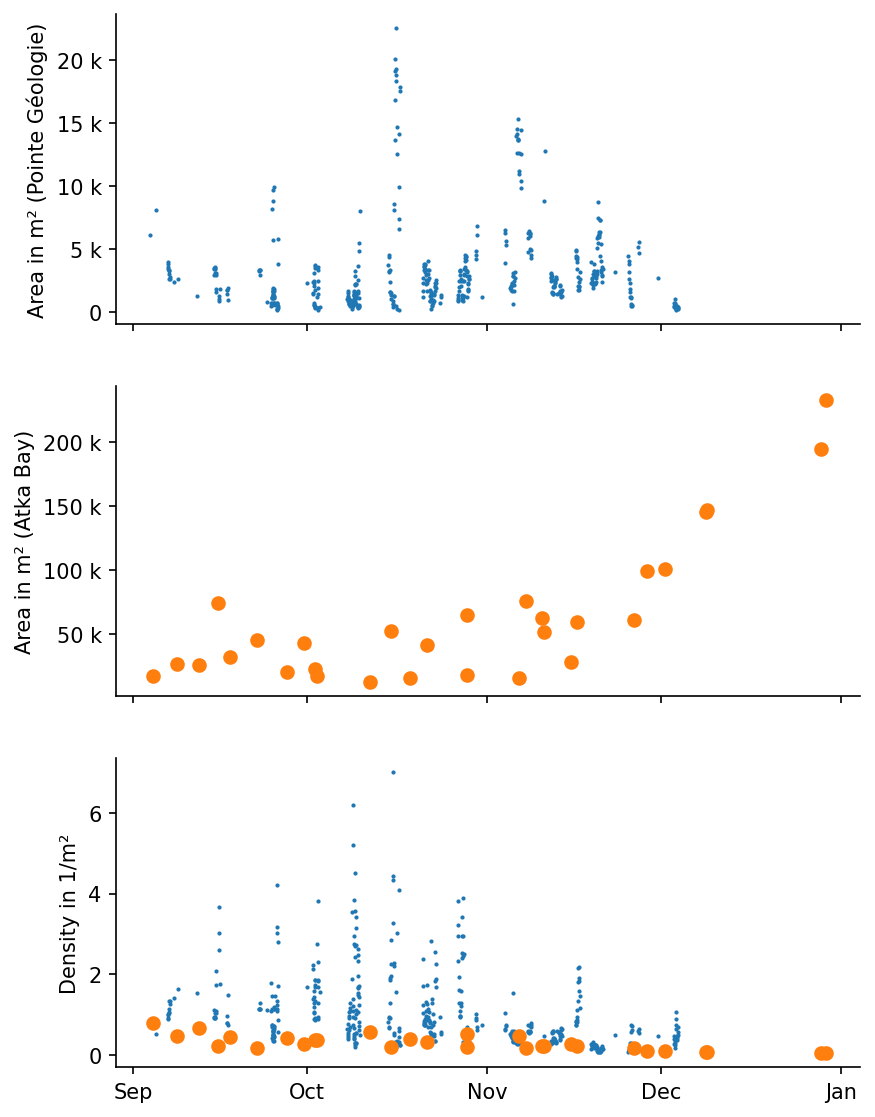

In [334]:
fig, axes = plt.subplots(3,1, sharex=True, figsize=(6.4,9.3), dpi=150)

axPG, axAB = axes[:2]
mAB = dfArea["colony_name"]=="Atka Bay"
mPG = dfArea["colony_name"]=="Pointe Géologie"

axPG.scatter(*dfArea.loc[mPG, ["ts2","A"]].values.T, s=1)
axAB.scatter(*dfArea.loc[mAB, ["ts2","A"]].values.T, c="C1" )

ax = axes[2]
ax.scatter(*dfArea.loc[mPG, ["ts2","rho"]].values.T, s=1)
ax.scatter(*dfArea.loc[mAB, ["ts2","rho"]].values.T, )

axes[0].set_ylabel("Area in m² (Pointe Géologie)")
axes[1].set_ylabel("Area in m² (Atka Bay)")
axes[2].set_ylabel("Density in 1/m²")

ax = axes[2]
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
for ax in axes[:2]:
    ax.yaxis.set_major_formatter(mtick.EngFormatter(unit=""))
for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    

In [314]:
# mask nan values
m = ~dfArea[["rho", "rho", "temp_airK", "met_rad", "met_ff10", "met_humc"]].isna().any(1)

with phaseTransitionModel(
                 theano.shared(dfArea.loc[m,"temp_airK"].T.values),
                 theano.shared(dfArea.loc[m,"met_ff10"].T.values),
                 theano.shared(dfArea.loc[m,"met_rad"].T.values),
                 theano.shared(dfArea.loc[m,"met_humc"].T.values),
) as model:
    # observation error distribution width
    sigma = pm.Exponential("sigma", 1/0.1, )
    # observation error distribution
    rho_obs = pm.Lognormal("rho",
                           mu=T.log(model.rho_pred),
                           sd=sigma,
                           observed=theano.shared(dfArea.loc[m,"rho"].T.values)
                          )

    # sampling
    nChains = 4
    tracePhase = pm.sample(1000, start=None, step=pm.NUTS(target_accept=0.9), cores=nChains, tune=3000, compute_convergence_checks=False, return_inferencedata=True)
    

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Tc, cH, cR, cW, cT]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 68 seconds.


## posterior predictive sampling

In [363]:

m = ~dfArea[["rho", "temp_airK", "met_rad", "met_ff10", "met_humc"]].isna().any(1)

with phaseTransitionModel(
                 theano.shared(dfArea.loc[m,"temp_airK"].T.values),
                 theano.shared(dfArea.loc[m,"met_ff10"].T.values),
                 theano.shared(dfArea.loc[m,"met_rad"].T.values),
                 theano.shared(dfArea.loc[m,"met_humc"].T.values),
) as model:
    sigma = pm.Exponential("sigma", 1/0.1, )
    rho_obs = pm.Lognormal("rho",
                           mu=T.log(model.rho_pred),
                           sd=sigma,
                           observed=theano.shared(dfArea.loc[m,"rho"].T.values)
                          )
    
    t_temp = theano.shared(dfArea.loc[m,"temp_airK"].T.values)
    t_wind = theano.shared(dfArea.loc[m,"met_ff10"].T.values)
    t_rad = theano.shared(dfArea.loc[m,"met_rad"].T.values)
    t_humc = theano.shared(dfArea.loc[m,"met_humc"].T.values)
    t_area = theano.shared(dfArea.loc[m,"A"].T.values)

    obs = [
        rho_obs,
        pm.Deterministic("rho_pred", model.rho_pred),
        pm.Deterministic("Ta", t_temp + (model.cW * t_wind + model.cR * t_rad + model.cH * t_humc)/model.cT),
        pm.Deterministic("b0_", -1./model.cT),
        pm.Deterministic("cW_", model.cW/model.cT),
        pm.Deterministic("cR_", model.cR/model.cT),
        pm.Deterministic("cH_", model.cH/model.cT),
        pm.Deterministic("Tc_", model.Tc/model.cT),
        pm.Deterministic("Tc_C", model.Tc/model.cT - 273.15),
        pm.Deterministic("Ta_C", t_temp + (model.cW * t_wind + model.cR * t_rad + model.cH * t_humc)/model.cT - 273.15),
    ]
    phase_ppc = pm.fast_sample_posterior_predictive(tracePhase, var_names=[rv.name for rv in obs], keep_size=True)
dfArea["Ta_C"] = phase_ppc["Ta_C"].mean((0,1))
dfArea["rho_pred"] = phase_ppc["rho_pred"].mean((0,1))


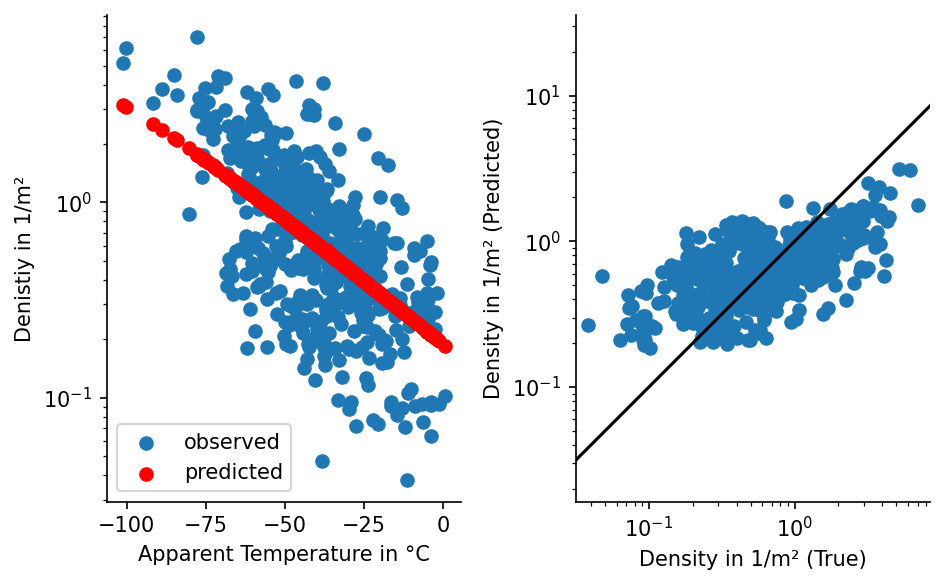

In [364]:
fig, axes = plt.subplots(1,2,figsize=(6.4,4), dpi=150)

ax = axes.flatten()[0]
ax.scatter(*dfArea[["Ta_C", "rho"]].values.T, label="observed")
ax.scatter(*dfArea[["Ta_C", "rho_pred"]].values.T, c="r", label="predicted")
ax.semilogy()
ax.legend()
ax.set_ylabel("Denistiy in 1/m²")
ax.set_xlabel("Apparent Temperature in °C")

ax = axes.flatten()[1]
ax.scatter(*dfArea[["rho", "rho_pred"]].values.T)
ax.axline(xy1=(1,1), slope=1, color="k")
ax.loglog()
ax.set_xlabel("Density in 1/m² (True)")
ax.set_ylabel("Density in 1/m² (Predicted)")
ax.axis("equal")


for ax in axes.flatten():
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

fig.tight_layout()

# Study with satellite data

## Satellite and ground based colony area and meteorological data
Satellite data are from Labrousse 2021, Ground based Areas are from images recorded with SPOT and micrObs observatories.

In [365]:
dfSat = pd.read_excel("./Supplement/S20.xlsx").drop(columns="Unnamed: 0")
dfSat

,colony_name,ts,Count,CountChicks,A,temp_airK,met_ff10,met_rad,met_humc
0,Point Geologie (Ground),2014-09-10 23:00:49,900.000000,1081.000000,1284.503445,251.250000,1.300000,142.166667,93.225018
1,Point Geologie (Ground),2014-09-16 04:13:36,724.285714,647.428571,1371.714286,260.050000,4.600000,359.500000,42.146969
2,Point Geologie (Ground),2014-09-16 05:00:20,724.285714,647.428571,1371.714286,259.650000,7.300000,313.166667,45.745954
3,Point Geologie (Ground),2014-09-16 06:00:18,724.285714,647.428571,1371.714286,259.150000,4.600000,227.333333,43.675312
4,Point Geologie (Ground),2014-09-16 07:00:16,724.285714,647.428571,1371.714286,258.850000,10.900000,127.333333,44.958586
...,...,...,...,...,...,...,...,...,...
582,Stancomb-Wills (Satellite),2011-10-11 10:00:00,NaN,NaN,11540.820000,245.150497,3.953756,8.011555,75.415375
583,Stancomb-Wills (Satellite),2011-10-18 10:00:00,NaN,NaN,9488.866000,241.929581,2.194030,8.618667,104.428421
584,Stancomb-Wills (Satellite),2011-11-19 10:00:00,NaN,NaN,15267.160000,258.103760,2.407381,18.693333,65.087570
585,Stancomb-Wills (Satellite),2011-11-27 10:00:00,NaN,NaN,9863.186000,261.765869,4.758323,20.273773,59.841415


In [373]:
# get the day of the season and the season from timestamps (season starts on March 1st)
dfSat["ts2"] = pd.to_datetime([datetime(2011 + (M<3), 1, 1) + timedelta(days=d,hours=h,minutes=m, seconds=s) for M,d,h,m,s in zip(
    dfSat["ts"].dt.month, dfSat["ts"].dt.dayofyear, dfSat["ts"].dt.hour, dfSat["ts"].dt.minute, dfSat["ts"].dt.second)])
dfSat["season"] = dfSat["ts"].dt.year - (dfSat["ts"].dt.month<3)
dfSat["day"] = (dfSat["ts2"]-datetime(2011,1,1)).dt.days
dfSat["CountSum"] = dfSat["Count"] + dfSat["CountChicks"]

In [398]:

def getLastDay(lat, angle=0):
    times = Time("2011-6-21 12:00:00") + np.arange(0, 183, 1)*u.day
    loc = EarthLocation(lat=lat*u.deg, lon=0*u.deg, height=0)
    sun_data = get_sun(times).transform_to(AltAz(obstime=times, location=loc))
    return (datetime(2011,6,21) + timedelta(days=int(np.sum(sun_data.alt<angle*u.deg)))).timetuple().tm_yday

latitudes = np.array([-66.662, -73.5, -75.3, -70.583333])
firstSunriseDay = [getLastDay(l)+27.4 for l in latitudes]
firstSunriseDay = {
    'Point Geologie (Ground)': firstSunriseDay[0],
    'Atka Bay (Ground)': firstSunriseDay[3],
    'Coulman Island (Satellite)': firstSunriseDay[1],
    'Atka Bay (Satellite)': firstSunriseDay[3],
    'Stancomb-Wills (Satellite)': firstSunriseDay[2],
}
dfSat["firstSunrise"] = dfSat["colony_name"].apply(firstSunriseDay.get)

## Predict count based on meteorological data and colony area

In [385]:

m = ~dfSat[["A", "temp_airK", "met_rad", "met_ff10", "met_humc"]].isna().any(1)

with phaseTransitionModel(
                 theano.shared(dfSat.loc[m,"temp_airK"].T.values),
                 theano.shared(dfSat.loc[m,"met_ff10"].T.values),
                 theano.shared(dfSat.loc[m,"met_rad"].T.values),
                 theano.shared(dfSat.loc[m,"met_humc"].T.values),
) as model:
    t_area = theano.shared(dfSat.loc[m,"A"].T.values)
    obs = [
        pm.Deterministic("count_pred", t_area*T.maximum(1, model.rho_pred)), # Densities below 1 do not apply to satellite data, because they are classified pixelwise with one pixel ~ 1m²
    ]
    phase_ppc = pm.fast_sample_posterior_predictive(tracePhase, var_names=[rv.name for rv in obs], keep_size=True)

dfSat["count_pred"] = phase_ppc["count_pred"].mean((0,1))


### evauluate count for known count data

Text(0, 0.5, 'Count (Predicted)')

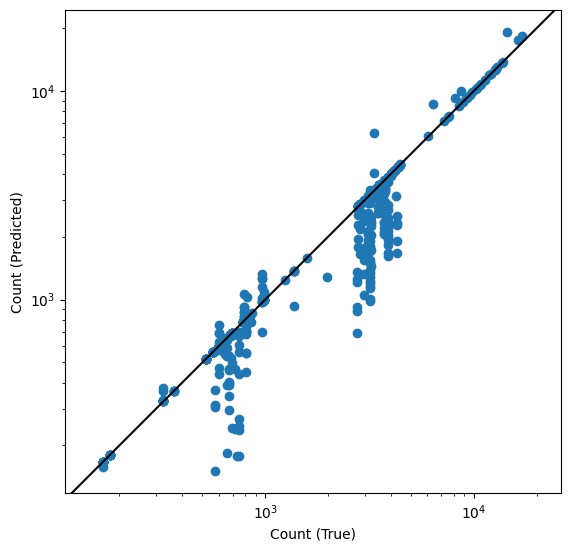

In [386]:
fig, ax = plt.subplots(figsize=(6.4,6.4), dpi=100)
ax.scatter(*dfSat[["CountSum", "count_pred"]].values.T)
ax.axline(xy1=(1e3,1e3), slope=1, color="k")
ax.loglog()
ax.axis("equal")
ax.set_xlabel("Count (True)")
ax.set_ylabel("Count (Predicted)")


## Define phenology model for satellite data

The model for satellite data contains mostly fixed parameter values. The number of breeding pairs and ratio of fledging chicks are free parameters, the arrival time at the colony is fixed according to the latitudinal shift we discovered between AB and PG, all other parameters are fixed to the average values from the manual count study.

In [388]:

class SatelliteModel(AbundanceModel):
    def __init__(self, t_polarNight, t_colony_id, *args, n_colonies=4, **kwargs):
        self.t_polarNight = t_polarNight
        self.t_colony_id = t_colony_id
        self.n_colonies = n_colonies
        super().__init__(*args, **kwargs)
    def create(self, t_tsd, overlapTrips = 3, singleTrips = 10, nSamples=11, observed={}):
        shape0 = (nSamples,)
        shape1 = (11,nSamples,)
        shape2 = ( 7,nSamples,)
        self.t_tsd = t_tsd
        
        self.shape0 = shape0
        self.shape1 = shape1
        self.shape2 = shape2
        
        # Model for number of breeders: every colony has a global average  "nPairs_" that underlies an exponential distribution
        # 6485 was fitted from the list of colony sizes provided by Fretwell 2012
        self.N = pm.Exponential("nPairs_", 1./6485, shape=self.n_colonies)
        # The global average can vary per year on a logarithmic scale with width nPairs_sd (0.02 would acount for ~2% change per year)
        # as nPairs_sd is a free parameter, we allow for arbitrary inter year variation at a colony.
        self.N_sd = pm.Exponential("nPairs_sd", 1/0.02)
        self.N_mu_log = pm.Lognormal("nPairs_m", mu=T.log(1), sd=self.N_sd, shape=nSamples) #* self.N[self.t_colony_id]
        # The number of breeders per year is the expected value of the log -normal distribution.
        self.N_mu = pm.Deterministic("nPairs", self.N_mu_log * self.N[self.t_colony_id])
        
        # fixed hatching success
        self.hatchingSuccess = traceCounts.posterior["hatchingSuccess"].values.mean() * T.ones(shape=shape0)
        
        # fledging success is a free parameter just as in the "normal" model
        self.fledgingSuccess = pm.Uniform("fledgingSuccess", lower=0, upper=1.0, shape=(1,)+shape0)**(1/shape2[0]) *  T.ones(shape=shape2)
        
        # fixed parameters
        self.nonBreederProportion = T.ones(shape=shape0)
        self.matingTime_sd = 0 * T.ones(shape0)
        self.matingTime_mu = traceCounts.posterior["matingTime"].values.mean() * T.ones(shape=shape0)
        self.breedingTime_sd = traceCounts.posterior["breedingStd"].values.mean() * T.ones(shape=shape0)
        self.breedingTime_mu = traceCounts.posterior["breedingTime"].values.mean() * T.ones(shape=shape0)
        
        # arrival time will be set so that the critical date for chick rearing (end of polar night) aligns with hatching.
        self.arrivalTime_mu = self.t_polarNight-self.breedingTime_mu-self.matingTime_mu
        self.arrivalTime_sd = traceCounts.posterior["arrivalStd"].values.mean() * T.ones(shape=shape0)
        
        # Fixed parameters for 
        sea_max = traceCounts.posterior["sea_max"].values.mean() * T.ones(shape=(1,)+shape0)
        sea_min = traceCounts.posterior["sea_min"].values.mean() * T.ones(shape=(1,)+shape0)
        col_max = traceCounts.posterior["col_max"].values.mean() * T.ones(shape=(1,)+shape0)
        col_min = traceCounts.posterior["col_min"].values.mean() * T.ones(shape=(1,)+shape0)
        sea_fem = traceCounts.posterior["sea_fem"].values.mean() * T.ones(shape=(1,)+shape0)
    
        
        One2Zero = 1 - T.arange(shape1[0]+1)/shape1[0]
        self.col_mu = (col_max-col_min)*One2Zero[:-1,None] + col_min
        self.last_mu = ((col_max-col_min)*One2Zero[-1:,None] + col_min)[0]
        
        One2Zero = T.minimum(1, 1 - (T.arange(shape1[0])-1)/(shape1[0]-2))
        self.sea_mu = (sea_max-sea_min)*One2Zero[:,None] + sea_min
        self.sea_mu = T.where(T.eq(T.arange(shape1[0]),1)[:,None],sea_fem ,self.sea_mu)
        self.sea_mu = T.where(T.eq(T.arange(shape1[0]),2)[:,None],sea_fem ,self.sea_mu)
        self.sea_mu = T.where(T.eq(T.arange(shape1[0]),3)[:,None],self.sea_mu-sea_fem ,self.sea_mu)
        
        self.last_sd = 0*T.ones(shape=shape0)
        self.col_sd =  0*T.ones(shape=shape1)
        self.sea_sd =  0*T.ones(shape=shape1)
        self.build()



In [436]:
# enumerate the season/colony to fit each season individualy
seasonColonyDictSat = {
 0: (2014, 'Point Geologie (Ground)'),
 1: (2015, 'Point Geologie (Ground)'),
 2: (2016, 'Point Geologie (Ground)'),
 3: (2017, 'Point Geologie (Ground)'),
 4: (2018, 'Atka Bay (Ground)'),
 5: (2019, 'Atka Bay (Ground)'),
 6: (2020, 'Atka Bay (Ground)'),
 7: (2011, 'Coulman Island (Satellite)'),
 8: (2011, 'Atka Bay (Satellite)'),
 9: (2011, 'Stancomb-Wills (Satellite)')
                       }
seasonColonyDictSat_inv = dict([[v,k] for k,v in seasonColonyDictSat.items()])
dfSat["season_colony_id"] = [seasonColonyDictSat_inv[(s,c)] for s,c in dfSat[["season", "colony_name"]].values]

# number of animals in season x day shape
totalCountsSat = dfSat.groupby(["season_colony_id", "day"]).mean().unstack()["count_pred"].values.T
# day of the season
daysCountsSat = dfSat.groupby(["season_colony_id", "day"]).mean().unstack()["count_pred"].columns.values

colonyListSat = list(set([c for s,c in seasonColonyDictSat.values()]))
colony_id = np.array([colonyListSat.index(c) for s,c in seasonColonyDictSat.values()])
polar_night = np.array([firstSunriseDay[c] for s,c in seasonColonyDictSat.values()])


In [437]:

with SatelliteModel(
    theano.shared(polar_night),
    theano.shared(colony_id),
    theano.shared(daysCountsSat),
    name="", nSamples=len(seasonColonyDictSat), n_colonies=len(colonyListSat)) as model:
    # masking array to remove missing data days in each season
    t_abundance_mask = theano.shared(~np.isnan(totalCountsSat), broadcastable=(False,False))
    
    # error distribution widths
    sigma = pm.Exponential("sigma", 1/0.1, shape=(1, len(seasonColonyDictSat)))
    sigmaNB = pm.Exponential("sigmaNB", 1./100, shape=(1, len(seasonColonyDictSat)))
    
    # observed distribution: this is where data and model are brought together. 
    # theano calculates likelihood functions for the model parameters based on this distribution.
    # The likelihood function is comparable to a loss function in NN: it returns a goodness of fit from observed values and parameter values.
    # It is used for MCMC sampling.
    N_obs = pm.Lognormal('Abundance',
                         mu=T.log(model.allPresentP+model.allPresentC+sigmaNB)[t_abundance_mask],
                         sd=(sigma * T.ones_like(t_abundance_mask))[t_abundance_mask],
                         observed=totalCountsSat[~np.isnan(totalCountsSat)]
                        )    
    # The NUT-Sampler (No-U-Turn) optimizes the parameter values for the likelihood function.
    # It is very efficient in number of samples, as it does not run back and forth on the same "line" in the parameter space,
    # but sample computation is more demanding, as it computes multiple interpolation points per step.
    # The NUT-Sampler is especially usefull for complex parameter landscapes like in our optimization.
    nChains = 6
    traceSat = pm.sample(1000, start=None, step=pm.NUTS(target_accept=0.99), cores=nChains, tune=1000, compute_convergence_checks=False, return_inferencedata=True)
    

Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigmaNB, sigma, fledgingSuccess, nPairs_m, nPairs_sd, nPairs_]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 558 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9649867607670016, but should be close to 0.99. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [439]:
# helper function to extract values from the posterior predictive chain (ppc)
def arrFromPPC(ppc, key, flatten=True):
    arr = np.asarray(ppc[key], dtype=float)
    if flatten:
        return arr.reshape((-1, *arr.shape[2:])) 
    else:
        return arr
daysCountsSat2 = np.arange(59,425)   
with SatelliteModel(
    theano.shared(polar_night),
    theano.shared(colony_id),
    theano.shared(daysCountsSat2),
    name="", nSamples=len(seasonColonyDictSat), n_colonies=len(colonyListSat)) as model:
    
    #t_abundance_mask = theano.shared(~np.isnan(totalCountsSat), broadcastable=(False,False))
    ## error distribution widths
    #sigma = pm.Exponential("sigma", 1/0.1, shape=(1, len(seasonColonyDictSat)))
    #sigmaNB = pm.Exponential("sigmaNB", 1./100, shape=(1, len(seasonColonyDictSat)))
#
    ## create observed value as above (to sample the distribution of number of individuals per day)
    #N_obs = pm.Lognormal('Abundance',
    #                     mu=T.log(model.allPresentP+model.allPresentC+sigmaNB)[t_abundance_mask],
    #                     sd=(sigma * T.ones_like(t_abundance_mask))[t_abundance_mask],
    #                     observed=totalCountsSat[~np.isnan(totalCountsSat)]
    #                    )    
    ## Same as above, but without the masking, to interpolate the missing adult count values.
    #N2_obs = pm.Lognormal('Abundance2',
    #                 mu=T.log(model.allPresentP+model.allPresentC+sigmaNB),
    #                 sd=(sigma * T.ones_like(t_abundance_mask)),
    #                 observed=np.zeros_like(totalCountsSat), # the observed value does not play a role anymore after sampling, it just helps theano to get the array shapes right
    #                )    

    
    obs = [
    #N_obs, # number of adults for each observed day (with error distribution)
    #N2_obs, # number of adults for every day (with error distribution)
    
    # the followin "deterministic" values are predicted from the model parameter distributions and do not carry an additonal observation error distribution
    pm.Deterministic('abundance_adults', model.allPresentP + sigmaNB), # predicted number of adults for every day
    pm.Deterministic('abundance', model.allPresentP + model.allVisibleC + sigmaNB), # predicted number of animals for every day
    pm.Deterministic('chickV_abundance', model.allVisibleC), # predicted number of emmancipated chicks for every day

    ]
    # perform posterior predictive sampling
    sat_ppc = pm.fast_sample_posterior_predictive(traceSat, var_names=[rv.name for rv in obs], keep_size=True)

# extract distribution values from ppc    
#sat_abundancePPC =       arrFromPPC(sat_ppc, "Abundance2")
sat_directAbundancePPC = arrFromPPC(sat_ppc, "abundance")
sat_abundanceAdults =   arrFromPPC(sat_ppc, "abundance_adults")
sat_abundanceChicksV =   arrFromPPC(sat_ppc, "chickV_abundance")


In [426]:
colonyListSat

['Point Geologie (Ground)',
 'Point Geologie (Ground)',
 'Point Geologie (Ground)',
 'Point Geologie (Ground)',
 'Atka Bay (Ground)',
 'Atka Bay (Ground)',
 'Atka Bay (Ground)',
 'Coulman Island (Satellite)',
 'Atka Bay (Satellite)',
 'Stancomb-Wills (Satellite)']

In [ ]:
one_sigma = 68.3
one_sigma_interval = (50-one_sigma/2, 50+one_sigma/2)

ts_days = np.array([datetime(2011,1,1) + timedelta(days=int(d)) for d in daysCountsSat])
ts_days2 = np.array([datetime(2011,1,1) + timedelta(days=int(d)) for d in daysCountsSat2])

fig, axes = plt.subplots(5,2,dpi=200, figsize=(6.3,9.8))

for i, (s,c) in seasonColonyDictSat.items():
    ax = axes.flatten()[i]
    #iS = (s-2012)%10
    iS = colonyListSat.index(c)
    m = (dfSat["season"]==s)&(dfSat["colony_name"]==c)
    
    #ax.plot(*dfSat.loc[m, ["ts2", "count_pred"]].values.T, color="C%d"%iS, marker="o", markersize=2, linestyle="none")
    ax.plot(ts_days, totalCountsSat[...,i], color="C%d"%iS, marker="o", markersize=2, linestyle="none")
    
    ax.fill_between(ts_days2, *np.percentile(sat_directAbundancePPC[:,:,i], one_sigma_interval, axis=0), color="C%d"%iS, alpha=0.1, clip_on=False, zorder=-1)
    ax.fill_between(ts_days2, *np.percentile(sat_abundanceAdults[:,:,i], one_sigma_interval, axis=0), color="C%d"%iS, alpha=0.1, clip_on=False, zorder=-1)
    ax.fill_between(ts_days2, *np.percentile(sat_abundanceChicksV[:,:,i], one_sigma_interval, axis=0), color="C%d"%iS, alpha=0.1, clip_on=False, zorder=-1)
    
    ax.plot(ts_days2, sat_directAbundancePPC[...,i].mean(0), color="C%d"%iS, linestyle="-", alpha=0.5, clip_on=False)
    ax.plot(ts_days2, sat_abundanceAdults[...,i].mean(0), color="C%d"%iS, linestyle=":", alpha=0.5, clip_on=False)
    ax.plot(ts_days2, sat_abundanceChicksV[...,i].mean(0), color="C%d"%iS, linestyle="--", alpha=0.5, clip_on=False)
    
    #shorthand = {"Atka Bay":"AB", "Pointe Géologie":"PG"}
    ax.set_title(" ".join([c, str(s)]))
    
#for ax in axesPG:
#    ax.set_ylim(-5e2, 12e3)
#for ax in axesAB:
#    ax.set_ylim(-1e3, 30e3)
    
for ax in axes.flatten():
    ax.set_xlim(datetime(2011,2,15), datetime(2012,2,1))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    
    ax.yaxis.set_major_formatter(mtick.EngFormatter(unit=''))
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

for ax in axes[:,1:].flatten():
    ax.set(yticklabels=[])

ax = axes[0,0]
handles = [
    ax.plot([],[], color="Grey", linestyle="-", alpha=0.5, label="Model Prediction Total (Mean)")[0],
    ax.plot([],[], color="Grey", linestyle=":", alpha=0.5, label="Model Prediction Adults (Mean)")[0],
    ax.plot([],[], color="Grey", linestyle="--", alpha=0.5, label="Model Prediction Chicks (Mean)")[0],
    ax.plot([],[], markersize=2, marker="o", linestyle="none", color="Grey", label="Number of Individuals (Total)")[0],
    ax.fill_between([],[],[], color="Grey", alpha=0.1, label="Model Prediction\n(central 68.3 percentile)"),
]

fig.legend(ncol=3, loc="upper center", handles=handles, bbox_to_anchor=(0.5, 0))

fig.subplots_adjust(left=0.07, bottom=0.025, right=1-0.01, top=1-0.023, wspace=0.05, hspace=0.4)
